# Updating Regional Timeseries for OISST Data

**Objective: Update all masked timeseries products to most current OISST data.**

## Product 2: Regional Timeseries of Anomalies

This is the second notebook for updating OISST data products. This series should be run in order, starting with `04_OISST_Update_Global_ts.ipynb`


**New Plan** Run them through the likelihood timeseries pathway. Export the subset as the masked timeseries. Do it in the mainstays folder as a test round, then transfer it over. We need to do the full thing for the NEFSC regions anyways so I could start there first so that I can move forward on size spectra work.

In [8]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask

#ensure we're in correct directory
os.chdir("/Users/akemberling/Box/NSF OKN Demo Data")

# Objective 1: Updating LME Timeseries

## Load Regional Polygons
 * Load LME's
 * Load GoM and GB

In [9]:
# This csv contains naming/number structure for the Large Marine Ecosystems
lme_info = pd.read_csv("~/Box/NSF OKN Demo Data/large_marine_ecosystems/lme_names_key.csv")
lme_info.head()

# The information below gives the name of the lme and the bounding polygon filename
test_lme = lme_info[lambda df: df["lme_name"] == "Gulf of California"]
test_lme

,lme_number,lme_name,full_poly_file,outer_bound_file
3,4,Gulf of California,LMEbb_04_all.geojson,LMEbb_04_bounding.geojson


## Load existing LME timeseries and associated polygons

Switching to the likelihood timeseries because they contain the climatology information.


In [10]:
# Need to load each one

# list to catch the dataframes
lme_timeseries = [] # timeseries of masked anomalies
lme_polygons = []   # polygons for the masks


# Super loop for all the LME's
for i, lme in lme_info.iterrows():
    
    # timeseries location info
    lme_name = lme["lme_name"].replace(" ", "_")  # Names of LME as variable names
    poly_path = lme["outer_bound_file"]           # Location to polygon file
    out_folder = "~/Box/NSF OKN Demo Data/oisst/likelihood_timeseries"
    grid_name = "OISSTv2_anom"
    
    # Path to the timeseries
    csv_path = f"{out_folder}/{grid_name}_{lme_name}.csv"
    
    #load the timeseries we want to append to:
    outdated_timeline = pd.read_csv(csv_path)
    outdated_timeline["time"] = pd.to_datetime(outdated_timeline["time"])
    lme_timeseries.append(outdated_timeline)
    
    # Then load the mask
    lme_mask = gpd.read_file(f"/Users/akemberling/Box/NSF OKN Demo Data/large_marine_ecosystems/{poly_path}")
    lme_polygons.append(lme_mask)
    

In [11]:
# glimpse the timeseries
lme_timeseries[0]

,time,sst,modified_ordinal_day,clim_sd,sst_clim,sst_anom,log_lik
0,1981-09-01,8.655925,245,0.819563,9.434293,-0.778368,1.170953
1,1981-09-02,8.870700,246,0.812581,9.446641,-0.575941,0.962583
2,1981-09-03,8.953409,247,0.810328,9.452046,-0.498637,0.897952
3,1981-09-04,9.391286,248,0.803185,9.460110,-0.068824,0.703440
4,1981-09-05,9.360794,249,0.815672,9.443022,-0.082228,0.720276
...,...,...,...,...,...,...,...
13631,2018-12-27,2.895705,362,1.398742,2.760845,0.134860,1.259160
13632,2018-12-28,2.821030,363,1.406107,2.719388,0.101642,1.262376
13633,2018-12-29,2.777724,364,1.421917,2.695842,0.081882,1.272602
13634,2018-12-30,2.787692,365,1.416499,2.670208,0.117484,1.270566


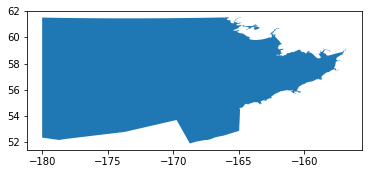

In [12]:
# Plot one
lme_polygons[0].plot()

## Calculate the Masked Timeseries on New Data
 
Loop through the lists of shapes and the new OISST data to create a timeseries of sea surface temperature for each LME.

In [13]:

#####  Calculate the masked timeseries  ####

# load the oisst data again
fpaths = []
for yr in range(2019, 2020 + 1):
    fpaths.append(f'~/Box/NSF OKN Demo Data/oisst/annual_observations/sst.day.mean.{yr}.v2.nc')

# Lazy-load the data itself using xr.open_mfdataset
grid_obj = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)

# variable name to mask and make timeline from
var_name = "sst"

# list to store them un-appended
new_ts = []

##### Super loop for all the LME's  ####
for i, lme in lme_info.iterrows():
    
    # lme naming convention
    lme_name = lme["lme_name"]
    shp_name = lme["lme_name"].replace(" ", "_")  # Names of LME as variable names
    
    # grab the shape:
    shp_obj = lme_polygons[i]
    
    
    #grab the timeseries to append to:
    lme_ts_full = lme_timeseries[i]
    
    
    # 1. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # 2. Mask the array with gom_mask to get nan test
    mask = area_mask.mask(grid_obj, lon_name = "lon", lat_name = "lat")

    # 3. Extract data that falls within the mask
    masked_ds = grid_obj.where(~np.isnan(mask))

    # 4. Calculate timeseries mean

    # Get the timeseries mean of the desired variable
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))
    masked_ts[f"{var_name}_stdev"] = getattr(masked_ds, var_name).std(dim = ("lat", "lon"))

    # 5. Change time index rownames to a column 

    # Masked Timeseries Dataframe
    masked_ts_df = masked_ts.to_dataframe()

    # Reset index, rename variables
    masked_ts_df = masked_ts_df.reset_index()[["time", var_name, f"{var_name}_stdev"]]

    
#     6. Load the LME Climatology
    
    
#     7. Subtract the Climatology to get Anomalies
    
    
#     8. Store in list
    
    # add to list
    new_ts.append(masked_ts_df)
    
    

## Compare them, ensure they match, then append

In [14]:
####  Compare how they match  ####

# Timeseries calculated previously
lme_timeseries[0].head()


,time,sst,modified_ordinal_day,clim_sd,sst_clim,sst_anom,log_lik
0,1981-09-01,8.655925,245,0.819563,9.434293,-0.778368,1.170953
1,1981-09-02,8.870700,246,0.812581,9.446641,-0.575941,0.962583
2,1981-09-03,8.953409,247,0.810328,9.452046,-0.498637,0.897952
3,1981-09-04,9.391286,248,0.803185,9.460110,-0.068824,0.703440
4,1981-09-05,9.360794,249,0.815672,9.443022,-0.082228,0.720276


In [43]:
# Timeseries just calculated
tester_ts = new_ts[0]

# Add modified ordinal day, for day-to-day calculation and leapyear adjustment
not_leap_year = tester_ts.time.dt.is_leap_year
march_or_later = tester_ts.time.dt.month >= 3
ordinal_day = tester_ts.time.dt.dayofyear
tester_ts["modified_ordinal_day"] = ordinal_day + (not_leap_year & march_or_later)

# check it
tester_ts



,time,sst,sst_stdev,modified_ordinal_day
0,2019-01-01,2.740661,2.050983,1
1,2019-01-02,2.729671,1.998232,2
2,2019-01-03,2.770120,1.955915,3
3,2019-01-04,2.802977,1.936900,4
4,2019-01-05,2.777155,1.954919,5
...,...,...,...,...
604,2020-08-27,10.893609,1.157982,241
605,2020-08-28,10.940541,1.157062,242
606,2020-08-29,10.806430,1.149048,243
607,2020-08-30,10.670644,1.169618,244


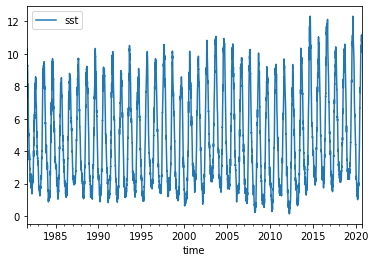

In [15]:
#Append them on the end if they match
append_test = pd.concat([ lme_timeseries[0][["time", "sst"]], new_ts[0][["time", "sst"]]])
append_test.plot("time", "sst")

## Match up the climatology info

Below is the function for getting the log likelihood of an observed sst anomaly, assuming normal distribution with mu = sst climatology mean and sd = climatology standard deviation.

In [57]:
# get likelihood
import math

def calc_ll(row):
    # log likelihood 
    n = 1
    anom  = row["sst_anom"]
    sigma = row["clim_sd"]
    mu    = row["sst_clim"]
    log_lik = n * math.log(2 * math.pi * (sigma ** 2)) / 2 + np.sum(((anom - mu)**2)/(2 * (sigma ** 2)))
    return log_lik

**Test Timeseries :**

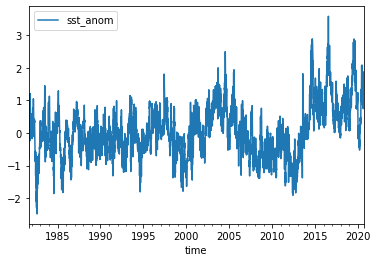

In [60]:

old_ts = lme_timeseries[0] # Previously calculated timeseries
tester_ts = new_ts[0] #newly calculated timeseries

# pull unique climatology values from existing timeline
clim = old_ts[["modified_ordinal_day", "sst_clim", "clim_sd"]]
clim = clim.drop_duplicates()
#mods.merge(lme_timeseries[0][["modified_ordinal_day", "sst_clim", "clim_sd"]])

# Make MOD for the new timeseries just calculated

# Add modified ordinal day, for day-to-day calculation and leapyear adjustment
not_leap_year = tester_ts.time.dt.is_leap_year
march_or_later = tester_ts.time.dt.month >= 3
ordinal_day = tester_ts.time.dt.dayofyear
tester_ts["modified_ordinal_day"] = ordinal_day + (not_leap_year & march_or_later)


# Merge
anom_timeline = tester_ts.merge(clim, how = "left", on = "modified_ordinal_day")


# Subtract climate mean
#Calc anoms
anom_timeline = anom_timeline.assign(sst_anom = anom_timeline["sst"] - anom_timeline["sst_clim"])


# Get likelihood
anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)

# Drop sst_stdev
del anom_timeline["sst_stdev"]


# Concatenate onto the original
append_test = pd.concat([ old_ts, anom_timeline ])
append_test
append_test.plot("time", "sst_anom")

## Run All Timeseries

In [63]:
##### Super loop for all the LME's  ####


# list to store them un-appended
appended_ts_list = []


for i, lme in lme_info.iterrows():
    
    # lme naming convention
    lme_name = lme["lme_name"]
    shp_name = lme["lme_name"].replace(" ", "_")  # Names of LME as variable names
    
    
    # Pull the Previously Calculated Timeseries
    old_ts = lme_timeseries[i] # Previously calculated timeseries

    
    # Pull the timeseries on the fresh data
    fresh_ts = new_ts[i] #newly calculated timeseries
    
    # pull unique climatology values from existing timeline
    clim = old_ts[["modified_ordinal_day", "sst_clim", "clim_sd"]]
    clim = clim.drop_duplicates()
    #mods.merge(lme_timeseries[0][["modified_ordinal_day", "sst_clim", "clim_sd"]])

    # Make MOD for the new timeseries just calculated

    # Add modified ordinal day, for day-to-day calculation and leapyear adjustment
    not_leap_year = fresh_ts.time.dt.is_leap_year
    march_or_later = fresh_ts.time.dt.month >= 3
    ordinal_day = fresh_ts.time.dt.dayofyear
    fresh_ts["modified_ordinal_day"] = ordinal_day + (not_leap_year & march_or_later)


    # Merge
    anom_timeline = fresh_ts.merge(clim, how = "left", on = "modified_ordinal_day")


    # Subtract climate mean
    #Calc anoms
    anom_timeline = anom_timeline.assign(sst_anom = anom_timeline["sst"] - anom_timeline["sst_clim"])


    # Get likelihood
    anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)

    # Drop sst_stdev
    del anom_timeline["sst_stdev"]


    # Concatenate onto the original
    appended_ts = pd.concat([ old_ts, anom_timeline ])
    
    # Add to list
    appended_ts_list.append(appended_ts)
    
    print(f"{lme_name} append succesful.")

East Bering Sea append succesful.
Gulf of Alaska append succesful.
California Current append succesful.
Gulf of California append succesful.
Gulf of Mexico append succesful.
Southeast U.S. Continental Shelf append succesful.
Northeast U.S. Continental Shelf append succesful.
Scotian Shelf append succesful.
Labrador - Newfoundland append succesful.
Insular Pacific-Hawaiian append succesful.
Pacific Central-American Coastal append succesful.
Caribbean Sea append succesful.
Humboldt Current append succesful.
Patagonian Shelf append succesful.
South Brazil Shelf append succesful.
East Brazil Shelf append succesful.
North Brazil Shelf append succesful.
Canadian Eastern Arctic - West Greenland append succesful.
Greenland Sea append succesful.
Barents Sea append succesful.
Norwegian Sea append succesful.
North Sea append succesful.
Baltic Sea append succesful.
Celtic-Biscay Shelf append succesful.
Iberian Coastal append succesful.
Mediterranean Sea append succesful.
Canary Current append succ

## Run the anomaly & likelihood information

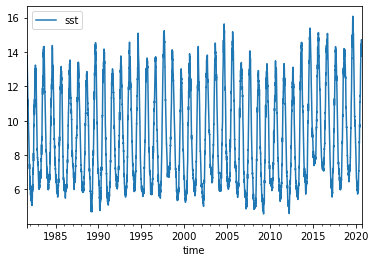

In [64]:
appended_ts_list[1].plot("time", "sst")

## Save the extended masked timeseries

Currently they are routed locally for QA/QC purposes

In [65]:
# Save csv file out
##### Super loop for all the LME's  ####
for i, lme in lme_info.iterrows():
    
    # lme information for saving
    lme_name = lme["lme_name"].replace(" ", "_").replace("-", "_").replace("__", "_").lower()  # Names of LME as variable names
    poly_path = lme["outer_bound_file"]           # Location to polygon file
    #out_folder = "~/Box/NSF OKN Demo Data/oisst/likelihood_timeseries"
    #out_folder = "~/Documents/oisst_mainstays/regional_timeseries/large_marine_ecosystems"
    grid_name = "OISSTv2_anom"
    
    # Path to the timeseries
    out_path = f"{out_folder}/{grid_name}_{lme_name}.csv"
    
    # And export
    appended_ts_list[i].to_csv(out_path, index = False)